# 数据预处理

### 1.文本评论，尝试筛选Star:1和Star:5取值样本各1W条，做2分类模型设计
### 2.文本长度取合理范围
### 3.关于停用词，标点、其它无关符号

### 文本分类任务实现
#### 1.文本到值转换
文字处理基本单元(token)字符或词汇
不重复字符构建字典
通过字典映射，文本转换token index
#### 2.转换值转变模型导入数据
数据还需要从文本到数值转换，使用Dataset封装上面处理逻辑
#### 3.模型结构搭建
#### 4.优化、损失函数
#### 5.模型训练优化

In [1]:
import pandas as pd
import torch 
import torch.nn as nn
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("./DMSC.csv")
df = df[df["Star"].isin([1,5])]
df

,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like
15,15,Avengers Age of Ultron,复仇者联盟2,2017-01-22,16,高压电,2015-05-08,1,什么破烂反派，毫无戏剧冲突能消耗两个多小时生命，还强加爱情戏。脑残片好圈钱倒是真的。,158
17,17,Avengers Age of Ultron,复仇者联盟2,2017-01-22,18,文文周,2015-04-24,5,机甲之战超超好看，比变形金刚强；人，神，变异人，人工智能互殴，强强强强；每一小段末句都是槽...,182
21,21,Avengers Age of Ultron,复仇者联盟2,2017-01-22,22,雨木木,2015-04-23,5,说实话其实剧情就那样吧，非漫威粉看着可能有的地方会get不到G点吧。（其实漫威卖的不是剧情...,90
25,25,Avengers Age of Ultron,复仇者联盟2,2017-01-22,26,呆子的世界,2015-05-01,5,没有了洛基这个小基仔真是觉得即墨如雪啊,84
40,40,Avengers Age of Ultron,复仇者联盟2,2017-01-22,41,办公室甜心,2015-05-10,5,看毕，我激动地对友人说，等等奥创要来毁灭台北怎么办厚，她拍了拍我肩膀，没事，反正你买了两份...,16
...,...,...,...,...,...,...,...,...,...,...
2125048,2125048,Zootopia,疯狂动物城,2017-01-04,141192,余召木,2016-03-08,5,啦啦啦,0
2125049,2125049,Zootopia,疯狂动物城,2017-01-04,141193,bethere311,2016-05-06,5,动物城的构建很棒！,0
2125052,2125052,Zootopia,疯狂动物城,2017-01-04,141197,Tosta,2016-03-05,5,六星好评！像头脑特工队那样惊喜！,0
2125054,2125054,Zootopia,疯狂动物城,2017-01-04,141199,P I T T,2016-03-05,5,对现实世界歧视和偏见的影射妙哉妙哉，不要害怕打破常规，try everything,0


In [3]:
# 取Comment字符长度在某个区间
df = df[df["Comment"].str.len().between(15,125)]
display(df)

,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like
15,15,Avengers Age of Ultron,复仇者联盟2,2017-01-22,16,高压电,2015-05-08,1,什么破烂反派，毫无戏剧冲突能消耗两个多小时生命，还强加爱情戏。脑残片好圈钱倒是真的。,158
21,21,Avengers Age of Ultron,复仇者联盟2,2017-01-22,22,雨木木,2015-04-23,5,说实话其实剧情就那样吧，非漫威粉看着可能有的地方会get不到G点吧。（其实漫威卖的不是剧情...,90
25,25,Avengers Age of Ultron,复仇者联盟2,2017-01-22,26,呆子的世界,2015-05-01,5,没有了洛基这个小基仔真是觉得即墨如雪啊,84
40,40,Avengers Age of Ultron,复仇者联盟2,2017-01-22,41,办公室甜心,2015-05-10,5,看毕，我激动地对友人说，等等奥创要来毁灭台北怎么办厚，她拍了拍我肩膀，没事，反正你买了两份...,16
43,43,Avengers Age of Ultron,复仇者联盟2,2017-01-22,44,LuDada,2015-05-12,1,不出意料得烂，喜欢这部电影的孩子，大概也喜欢变4……,33
...,...,...,...,...,...,...,...,...,...,...
2125046,2125046,Zootopia,疯狂动物城,2017-01-04,141190,拜女神,2016-03-04,5,笑到昏厥 剧情和讲的道理都挺好的 我想谈恋爱（,0
2125047,2125047,Zootopia,疯狂动物城,2017-01-04,141191,8排14座,2016-03-07,5,完美，未来是属于尊重细节的人们。,0
2125052,2125052,Zootopia,疯狂动物城,2017-01-04,141197,Tosta,2016-03-05,5,六星好评！像头脑特工队那样惊喜！,0
2125054,2125054,Zootopia,疯狂动物城,2017-01-04,141199,P I T T,2016-03-05,5,对现实世界歧视和偏见的影射妙哉妙哉，不要害怕打破常规，try everything,0


In [4]:
data = df.groupby(by="Star").head(10000)
display(data)

,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like
15,15,Avengers Age of Ultron,复仇者联盟2,2017-01-22,16,高压电,2015-05-08,1,什么破烂反派，毫无戏剧冲突能消耗两个多小时生命，还强加爱情戏。脑残片好圈钱倒是真的。,158
21,21,Avengers Age of Ultron,复仇者联盟2,2017-01-22,22,雨木木,2015-04-23,5,说实话其实剧情就那样吧，非漫威粉看着可能有的地方会get不到G点吧。（其实漫威卖的不是剧情...,90
25,25,Avengers Age of Ultron,复仇者联盟2,2017-01-22,26,呆子的世界,2015-05-01,5,没有了洛基这个小基仔真是觉得即墨如雪啊,84
40,40,Avengers Age of Ultron,复仇者联盟2,2017-01-22,41,办公室甜心,2015-05-10,5,看毕，我激动地对友人说，等等奥创要来毁灭台北怎么办厚，她拍了拍我肩膀，没事，反正你买了两份...,16
43,43,Avengers Age of Ultron,复仇者联盟2,2017-01-22,44,LuDada,2015-05-12,1,不出意料得烂，喜欢这部电影的孩子，大概也喜欢变4……,33
...,...,...,...,...,...,...,...,...,...,...
256031,256031,Chronicles of the Ghostly Tribe,九层妖塔,2017-01-25,7778,王宝驹,2015-11-09,1,我只能用搞笑的标签，可惜没有吐槽的标签！,0
256032,256032,Chronicles of the Ghostly Tribe,九层妖塔,2017-01-25,7779,minisola,2015-12-16,1,"剧情逗比,调色二比,绝色塑造无力,渣渣",0
256039,256039,Chronicles of the Ghostly Tribe,九层妖塔,2017-01-25,7786,╭ァ屺橋ξΘ,2015-09-30,1,不给行业毒瘤乐视和陆川送一毛钱，雇佣水军黑港囧，电影上映第二天就散播港囧的高清电影复刻版拷...,0
256043,256043,Chronicles of the Ghostly Tribe,九层妖塔,2017-01-25,7790,蚂蚁脸不大,2015-10-08,1,浪费时间浪费钱，虽然是9.9的特价票，我还是觉得不值,0


In [5]:
# labels = data.Star.values # 这里应该转换成 1，0，如果没懂可以看下一个代码块
# comments = data.Comment
# # 统计评论文本长度
# cmt_lens = [len(cmt) for cmt in comments]
# plt.hist(cmt_lens, bins=50)
# plt.show()
# plt.boxplot(cmt_lens)
# plt.show()
# # 筛选无关标点符号，格式控制符
# comments = comments.str.replace("。"," ").replace("，"," ").values
# comments[:10]

In [6]:
data = data[["Star", "Comment"]]
display(data)
data["labels"] = np.where(data["Star"] == 5, 1, 0)
display(data)

,Star,Comment
15,1,什么破烂反派，毫无戏剧冲突能消耗两个多小时生命，还强加爱情戏。脑残片好圈钱倒是真的。
21,5,说实话其实剧情就那样吧，非漫威粉看着可能有的地方会get不到G点吧。（其实漫威卖的不是剧情...
25,5,没有了洛基这个小基仔真是觉得即墨如雪啊
40,5,看毕，我激动地对友人说，等等奥创要来毁灭台北怎么办厚，她拍了拍我肩膀，没事，反正你买了两份...
43,1,不出意料得烂，喜欢这部电影的孩子，大概也喜欢变4……
...,...,...
256031,1,我只能用搞笑的标签，可惜没有吐槽的标签！
256032,1,"剧情逗比,调色二比,绝色塑造无力,渣渣"
256039,1,不给行业毒瘤乐视和陆川送一毛钱，雇佣水军黑港囧，电影上映第二天就散播港囧的高清电影复刻版拷...
256043,1,浪费时间浪费钱，虽然是9.9的特价票，我还是觉得不值


,Star,Comment,labels
15,1,什么破烂反派，毫无戏剧冲突能消耗两个多小时生命，还强加爱情戏。脑残片好圈钱倒是真的。,0
21,5,说实话其实剧情就那样吧，非漫威粉看着可能有的地方会get不到G点吧。（其实漫威卖的不是剧情...,1
25,5,没有了洛基这个小基仔真是觉得即墨如雪啊,1
40,5,看毕，我激动地对友人说，等等奥创要来毁灭台北怎么办厚，她拍了拍我肩膀，没事，反正你买了两份...,1
43,1,不出意料得烂，喜欢这部电影的孩子，大概也喜欢变4……,0
...,...,...,...
256031,1,我只能用搞笑的标签，可惜没有吐槽的标签！,0
256032,1,"剧情逗比,调色二比,绝色塑造无力,渣渣",0
256039,1,不给行业毒瘤乐视和陆川送一毛钱，雇佣水军黑港囧，电影上映第二天就散播港囧的高清电影复刻版拷...,0
256043,1,浪费时间浪费钱，虽然是9.9的特价票，我还是觉得不值,0


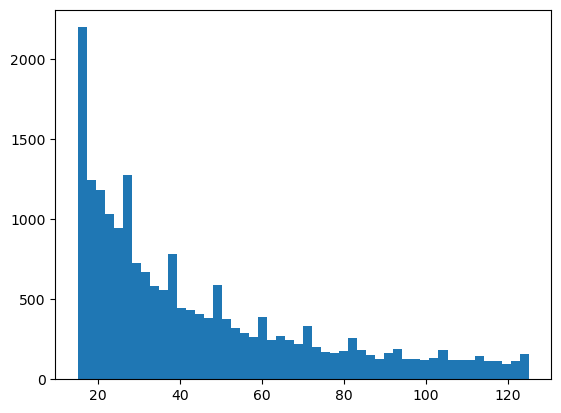

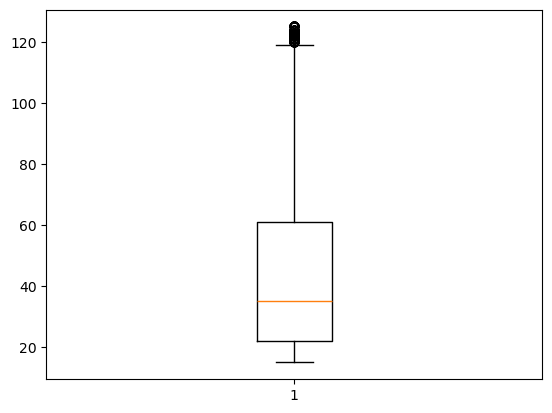

15           什么破烂反派，毫无戏剧冲突能消耗两个多小时生命，还强加爱情戏 脑残片好圈钱倒是真的 
21     说实话其实剧情就那样吧，非漫威粉看着可能有的地方会get不到G点吧 （其实漫威卖的不是剧情...
25                                  没有了洛基这个小基仔真是觉得即墨如雪啊
40     看毕，我激动地对友人说，等等奥创要来毁灭台北怎么办厚，她拍了拍我肩膀，没事，反正你买了两份...
43                           不出意料得烂，喜欢这部电影的孩子，大概也喜欢变4……
45                                  哪个保证一刀不剪的，不是剪了好几刀吗！
49     真的是全程无尿点 漫威在拍了这么多系列片之后再拿捏妇联2真是得心应手 笑点爆发点齐飞 拿锤...
50                                    绝逼不质疑尾灯的导演和编剧水平  
52     赶上第一波看好开心！大乱斗超好评！！！总之笑料和精彩程度都不减！所有的BG线都让人尴尬到内...
55                                      我是男脑残粉 所以怎么都好看 
Name: Comment, dtype: object

In [7]:
cmt_lens = data.loc[:,"Comment"].str.len()
plt.hist(cmt_lens, bins=50)
plt.show()
plt.boxplot(cmt_lens)
plt.show()
data.loc[:,"Comment"] = data.loc[:,"Comment"].str.replace("。"," ").replace("，"," ")
data.loc[:,"Comment"][:10]

In [8]:
# with open("../data/comments.bin", "bw") as f:    
#     pickle.dump((comments, labels))
#     print("语料处理保存完成。")


# 也可以用pandas处理
data[["Comment", "labels"]].to_pickle("./comments.bin")
print("语料处理保存完成。")

语料处理保存完成。


读取数据

In [9]:
with open("./comments.bin", "rb") as f:
    data = pickle.load(f)
data.head()

,Comment,labels
15,什么破烂反派，毫无戏剧冲突能消耗两个多小时生命，还强加爱情戏 脑残片好圈钱倒是真的,0
21,说实话其实剧情就那样吧，非漫威粉看着可能有的地方会get不到G点吧 （其实漫威卖的不是剧情...,1
25,没有了洛基这个小基仔真是觉得即墨如雪啊,1
40,看毕，我激动地对友人说，等等奥创要来毁灭台北怎么办厚，她拍了拍我肩膀，没事，反正你买了两份...,1
43,不出意料得烂，喜欢这部电影的孩子，大概也喜欢变4……,0
